# Facial Recognition App

Utilising siamese neural network for one shot recognition

In [ ]:
# Import dependencies
import cv2
import os, re
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import uuid
import time

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Flatten, Dense, Input
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.metrics import Precision, Recall

print("Packages imported successfully")

In [ ]:
# Set up GPU Growth
gpus = tf.config.list_physical_devices('GPU')

for gpu in gpus:
    details = tf.config.experimental.get_device_details(gpu)
    print(f"{gpu} ->", details)
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU {gpu} memory growth set to True")

In [ ]:
# Create folder structures
## Anchor - primary image; Verification - positive (1) or negative (0) images

POS_PATH = os.path.join("data", "positive")
NEG_PATH = os.path.join("data", "negative")
ANCHOR_PATH = os.path.join("data", "anchor")

In [ ]:
# Make directories if they don't exist
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANCHOR_PATH, exist_ok=True) 

## Collect Positive, Negative, and Anchor data
Positive (webcam), Negative (lael faces in wild), and Anchor (webcam)

In [ ]:
# # Move lfw data to negative folder (data/negative)
# lfw_base_path = "/Users/scottpitcher/Downloads/lfw-deepfunneled"
# lfw_path = os.listdir(lfw_base_path)

# # Look over all directories, then each file within
# for directory in lfw_path:
#     dir_path = os.path.join(lfw_base_path, directory)
#     if ".DS_Store" in directory:
#         continue
#     for file in os.listdir(dir_path):        
#         EX_PATH = os.path.join(lfw_base_path, directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)
    
# print("Data transfer completed!")

In [ ]:
# # Check size of pictures (should be 250x250)
# with Image.open("data/negative/Aaron_Eckhart_0001.jpg") as img:
#     width, height = img.size
#     print(f"Width: {width}px, Height: {height}px")


### Collect positives/anchor classes

In [ ]:
# Our frame is 250x250, but when cropping, need to ensure faces are in frame
# Below vars allow for facial centering in crop
start_height = 400
start_width = 600
frame_size = 800

cap = cv2.VideoCapture(1)

while cap.isOpened:
    ret, frame = cap.read()

    # Cut frame down
    frame = frame[start_height: start_height+frame_size,
                  start_width:start_width+frame_size,
                  :]
    
    # Collect anchors
    if cv2.waitKey(1)& 0XFF == ord('a'):
        # Create unique path/filename in Anchor folder
        imgname = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save anchor image
        cv2.imwrite(imgname, frame)
 

    # Collect positives
    if cv2.waitKey(1)& 0XFF == ord('p'):
        # Create unique path/filename in Positive folder
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save positive image
        cv2.imwrite(imgname, frame)

    # Show image
    cv2.imshow('Image Collection', frame)

    # End video capture when 'q' pressed
    if cv2.waitKey(1)& 0XFF == ord('q'):
        break

time.sleep(1)

# Release cam
cap.release()
# Close image show frame
cv2.destroyAllWindows()
cv2.waitKey(1)

## Load and Preprocess Images

In [ ]:
# Obtain files from image directories
# utilises data generator to loop through directory and take all jpg's (max. 300)
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

#### Preprocessing

In [ ]:
def preprocess(file_path):
    """Function to preprocess images"""
    # Get raw byte data
    byte_img = tf.io.read_file(file_path)
    
    # Convert to image data
    img = tf.io.decode_jpeg(byte_img)

    # Resize for consistency
    img = tf.image.resize (img,(100,100))

    # Normalise image
    img = img/ 255.0

    return img

In [ ]:
# # Testing the function
# img = preprocess("data/anchor/e3e7e9fa-2777-11f0-ab37-9e71dd1041e9.jpg")

# img.numpy().max()

#### Create labelled dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

#### Build Train and Test partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# Dataloader pipeline
## Run preprocess twin fn
data = data.map(preprocess_twin)
## Cache images
data = data.cache()
## Shuffle up data for randomness
data = data.shuffle(buffer_size=256)

In [ ]:
# Training partition
## 70%
train_data = data.take(round(len(data)*0.7))
## Batches of 16
train_data = train_data.batch(16)
## Start preprocessing next batch
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
## 30%
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))

## Batches of 16
test_data = test_data.batch(16)
## Start preprocessing next batch
test_data = test_data.prefetch(8)

## Model Engineering

#### Embedding Layer

In [ ]:
def make_embedding():
    # Define input layer
    inp = Input(shape =(100,100,3), name = 'embed_input')
    
    # FIRST BLOCK
    ## First conv layer (64 filters, 10x10 filter, ReLU act.)
    c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
    ## First max pool layer
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)


    # SECOND BLOCK
    ## Second conv layer (128 filters, 7x7 filter, ReLU act.)
    c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
    ## Second max pool layer
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)


    # THIRD BLOCK
    ## Third conv layer (128 filters, 4x4 filter, ReLU act.)
    c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
    ## Third max pool layer
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)


    # FOURTH, FINAL BLOCK
    ## Fourth, Final conv layer (256 filters, 4x4 filter, ReLU act.)
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    ## Fully connected layer
    f1 = Flatten()(c4)
    ## Dense layer (sigmoid act. fn.)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
     
     
    return Model(inputs=inp, outputs=d1, name='embedding')

In [ ]:
embedding = make_embedding()
embedding.summary()

In [ ]:
# Siamese L1 distance class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # Distance calc
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)


#### Siamese Model

In [ ]:
# implementation of the keras CNN embeddings

def make_siamese_model():
    # Anchor input
    input_image = Input(name = 'anchor_img', shape = (100,100,3))
    
    # Validation input
    validation_image = Input(name = 'validation_img', shape = (100,100,3))
    
    # Embed images
    ## Embed anchor
    input_embd = embedding(input_image)

    ## Embed val
    val_embd = embedding(validation_image)

    # Run siamese distance
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(input_embd, val_embd)

    # Classification Layer
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs= [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

## Model Training

In [ ]:
## Set up loss fn
binary_cross_loss = tf.losses.BinaryCrossentropy()

## Set up optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
## Checkpoints established
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True) 
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt= opt, siamese_model = siamese_model)

In [ ]:
## Train step function
@tf.function
def train_step(batch):

    # Utilise GradientTape to collect gradient/derivative information
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image, and target
        X,y = (batch[:2], batch[2])
        
        # Forward pass
        yhat = siamese_model(X, training = True)

        # Calculate loss
        loss = binary_cross_loss(y,yhat)
    
    print(loss)
    
    # Calculate gradient for backprop
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calc updated weights and apply to model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))


    return loss

In [ ]:
## Build Training Loop
def train(data, START, EPOCHS):
    # Loop over epochs
    for epoch in range(START, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through batches
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        # Save training checkpoint
        if epoch % 10 ==0:
            checkpoint.save(file_prefix = checkpoint_prefix)


In [ ]:
## Training
EPOCHS = 50

ckpt_dir = "./training_checkpoints"
ckpt_meta = os.path.join(ckpt_dir, "checkpoint")
save_interval   = 10

latest = None
# Check for checkpoint
if os.path.exists(os.path.join(ckpt_dir, "checkpoint")):
    latest = tf.train.latest_checkpoint(ckpt_dir)
if latest:
    # latest is something like ".../ckpt-3"
    ckpt_idx    = int(latest.split("-")[-1])        # → 3
    last_epoch  = ckpt_idx * save_interval         # → 3*10 = 30
    start_epoch = last_epoch + 1                   # → 31
    print(f"Restoring from {latest}; resuming at epoch {start_epoch}")
    checkpoint.restore(latest).expect_partial()
else:
    start_epoch = 1
    print("No checkpoint found; starting from epoch 1")

with tf.device('/GPU:0'):
    train(train_data,start_epoch, EPOCHS)

In [ ]:
# Save weights
siamese_model.save('./models/siamese_model.keras')

## Model Evaluation

In [ ]:
# Read in model
filepath= './models/siamese_model.keras'
custom_objects ={
        'L1Dist':L1Dist,
        'BinaryCrossentropy':tf.losses.BinaryCrossentropy,
        }

# Reload model 
siamese_model = tf.keras.models.load_model(
    filepath=filepath,
    custom_objects = custom_objects
    )

if siamese_model:
    print("Model loaded successfully")

In [147]:
def batch_eval():
    # Get batch of test data
    test_input, test_val, y_true = test_data.as_numpy_iterator().next()
    # Make predictions
    predictions = siamese_model.predict([test_input, test_val])
    print("Predictions:\n", [1 if prediction > 0.5 else 0 for prediction in predictions])
    print("Actual:\n", [int(yhat) for yhat in y_true])
    
    # Create recall metric object
    m = Recall()
    m.update_state(y_true, predictions)
    print("Recall:",m.result().numpy())

    # Create precision metric object
    p = Precision()
    p.update_state(y_true, predictions)
    print("Precision:",p.result().numpy())

In [151]:
batch_eval()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predictions:
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Actual:
 [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
Recall: 0.6666667
Precision: 1.0


### Which pixels are driving the decision?

Using idx=6, true=1.0, pred=0.57


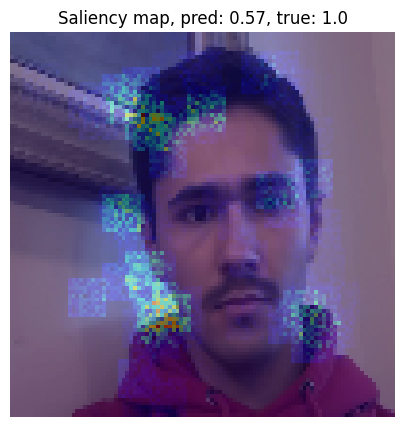

In [153]:
# Grab one eval sample (batched)
# test_input, test_val, y_true = test_data.as_numpy_iterator().next()

# pick a confident positive if possible
pos = np.where(y_true==1)[0]
idx = int(pos[0]) if len(pos)>0 else 0
anchor     = tf.convert_to_tensor(test_input[idx:idx+1], dtype=tf.float32)
validation = tf.convert_to_tensor(test_val  [idx:idx+1], dtype=tf.float32)
pred = siamese_model([anchor, validation])[0,0]
print(f"Using idx={idx}, true={y_true[idx]}, pred={pred:.2f}")

# Compute gradient of score w.r.t. the anchor image
with tf.GradientTape() as tape:
    tape.watch(anchor)
    score = siamese_model([anchor, validation])[0,0]
grads = tape.gradient(score, anchor)[0]             # shape (100,100,3)

# Convert to a single‐channel saliency map
saliency = tf.reduce_max(tf.abs(grads), axis=-1)    # (100,100)
saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)
saliency = saliency.numpy()

# Colorize & overlay
heat = (saliency*255).astype(np.uint8)
heat = cv2.applyColorMap(heat, cv2.COLORMAP_JET)
heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

orig = (anchor[0].numpy()*255).astype(np.uint8)
overlay = cv2.addWeighted(orig, 0.6, heat, 0.4, 0)

# Display
plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis('off')
plt.title(f"Saliency map, pred: {pred:.2f}, true: {y_true[idx]}")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Grab one test pair
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
idx = int(np.where(y_true==1)[0][0]) if np.any(y_true==1) else 0
orig_anchor = (test_input[idx] * 255).astype(np.uint8)      # H×W×3 uint8
validation  = test_val  [idx:idx+1].astype(np.float32)      # (1,100,100,3)

# 2) Detect face bounding box
cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)
gray = cv2.cvtColor(orig_anchor, cv2.COLOR_RGB2GRAY)        # convert to grayscale
faces = cascade.detectMultiScale(gray, 1.1, 4)              # detect faces

if len(faces)==0:
    raise RuntimeError("No face detected in anchor image")
(x,y,w,h) = faces[0]                                         # take the first face

# 3) Crop to face and resize back to 100×100
face_crop = orig_anchor[y:y+h, x:x+w]                        # crop ROI
face_resized = cv2.resize(face_crop, (100,100))              # to model input size

# 4) Prepare batches for prediction
orig_batch = orig_anchor[np.newaxis, ...].astype(np.float32)/255.0     # (1,100,100,3)
face_batch = face_resized[np.newaxis, ...].astype(np.float32)/255.0    # (1,100,100,3)

# 5) Compute both scores
score_orig = siamese_model.predict([orig_batch, validation])[0,0]
score_face = siamese_model.predict([face_batch, validation])[0,0]

print(f"True label = {y_true[idx]:.0f}")
print(f"Score with ORIGINAL anchor : {score_orig:.3f}")
print(f"Score with FACE-ONLY anchor: {score_face:.3f}")

# 6) Visualize
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(orig_anchor);       axes[0].set_title("Original Anchor") 
axes[1].imshow(face_resized);      axes[1].set_title("Face-Only Anchor")
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Visualise results

In [ ]:
image_index = 7
# Set up figure
plt.figure(figsize= (10,8))

# First subplot
plt.subplot(1,2,1)
plt.title("Anchor Image")
plt.imshow(test_input[image_index])

# Second subplot
plt.subplot(1,2,2)
plt.title(f"Test Image: {'Positive' if y_true[image_index] == 1.0 else 'Negative'}")
plt.imshow(test_val[image_index])

# Show image
plt.show()

## Save model

## Real time testing

In [ ]:
# Verification Function
def verify(model = siamese_model, ver_thresh = 0.6, det_thresh = 0.5):
    results = []
    # Loop through each file in the verification folder
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        # Preprocess live image
        input_img = preprocess(os.path.join('application_data','input_image', 'input_image.jpg'))
        # preprocess val image
        validation_img = preprocess(os.path.join('application_data','verification_images', image))
        
        # Predict if match
        prediction = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        
        # Append results
        results.append(prediction)
    
    ## results = [1 if result > det_thresh else 0 for result in results]
    detection = np.sum(np.array(results)>det_thresh)

    results_avg  = detection/len(results)
    print("Match proportion:", results_avg)

    # Utilise verification threshold to determine if match or not
    verified = 'Positive' if results_avg > ver_thresh else 'Negative'
    
    return verified

    # Detection Threshold: Metric above which a prediction is considered positive
    # Verification Threshold: Proportion of positive predictions /total positive samples

In [ ]:
## Real time verification
verify()

## OpenCV Real Time Verification

In [ ]:
# Reusing earlier code to resize frame
start_height = 400
start_width =  600
frame_size =   800

cap = cv2.VideoCapture(1)
cv2.namedWindow('Verification', cv2.WINDOW_NORMAL)
cv2.startWindowThread()

while cap.isOpened():
    ret, frame = cap.read()
    # Cut frame down
    frame = frame[start_height: start_height+frame_size,
                  start_width:start_width+frame_size,
                  :]

    cv2.imshow('Verification', frame)

    key = cv2.waitKey(10) & 0xFF
    # Verification Trigger
    if key == ord('v'):
        # Save input image to input_image folder (override anything there)
        cv2.imwrite(os.path.join('application_data','input_image', 'input_image.jpg'), frame)
        verified = verify()
        print("Result:",verified)

    if key == ord('q'):
        break

cap.release()
cv2.destroyWindow('Verification')
cv2.waitKey(1)